Elazar Fine

https://www.kaggle.com/elfein

In this competition we are given a dataset of passengers that were aboard the titanic when it drowned, with features for each passenger like `Sex`, `Age` `Pclass` etc and if they survived. 
We are to predict (`Binary Classification`) wether or not other passengers which we are not told wether they survived or not, in fact did.




# Imports and definitions

In [1]:
!pip install --upgrade pandas_profiling==2.9.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import pipeline

!pip install --upgrade plotly
import plotly.express as px

!pip install sweetviz
import sweetviz as sw

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20

In [2]:
test_df  = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

show_graphs = True

# Data Cleanup & Preprocessing

In [3]:
# function to drop a column from the df
def drop_col(df, col_name):
    df.drop([col_name], axis=1, inplace=True)
    
# Drop PassengerId, since it's not relevant to survival
drop_col(train_df, 'PassengerId')
# Can't drop for test_df since it's required for submission

# As we can see, `Ticket` which is not numerical has 681 unique values, and will be irrelavant or too difficult to categorize, so we can remove it.
# We will also remove the `Name` column for the same reason.
drop_col(train_df, 'Ticket')
drop_col(test_df,  'Ticket')
drop_col(train_df, 'Name')
drop_col(test_df,  'Name')

# replace all empty values to np.NaN values
train_df.replace('', np.NaN, inplace=True)
train_df.fillna(np.NaN, inplace=True)
test_df.replace('', np.NaN, inplace=True)
test_df.fillna(np.NaN, inplace=True)

# 'U' stands for `Unknown`
train_df['Embarked'].fillna("U", inplace=True)
test_df['Embarked'].fillna("U", inplace=True)

In [4]:
# replace all the column's empty values with the column's mean value or a random one (50% chance for value around mean) 
# this is to avoid stack too many rows with the same exact value, but still being better than random.
def fill_na_random_or_mean(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df_null = df[df[column_name].isnull()]
    mean = round(df_not_null[column_name].mean())
    std = round(df_not_null[column_name].std())
    df[column_name] = df[column_name].apply(
        lambda x: np.random.choice([
            mean,
            mean - std,
            mean + std,
            np.random.choice(df_not_null[column_name]),
            np.random.choice(df_not_null[column_name]),
            np.random.choice(df_not_null[column_name])
        ]) if pd.isnull(x) else x
    )

# We can see that in `Cabin` we are missing 687 out of 891 values, so we will consider dropping it if we won't be able to extrapolate something meaninful for the valid values it has.
# We can see that in `Age` we are missing 177 out of 891 values, so we will fill those with the columns mean.
    
fill_na_random_or_mean(train_df, 'Age')
fill_na_random_or_mean(test_df, 'Age')
fill_na_random_or_mean(test_df, 'Fare')

Cabins are in the format of `<deck-letter><room-number>` we can transform the column into a category of `Deck` for better encoding, instead of flat out removing the entire column.

In [5]:
import re
LetterSearcher = re.compile("(\w)")

def cabin_to_deck(df):
    df['Cabin'].fillna("U", inplace=True) # U - Unknown
    df['Deck']  = df['Cabin'].map(lambda cabin: cabin[0])
    drop_col(df, 'Cabin')

cabin_to_deck(train_df)
cabin_to_deck(test_df)

## Data Analysis

Let's display the cleaned data, and analyze it.
We will encode the the data just to show to graphically better (in some specific graphs), this is just a temporary measure as later we will encode it differently specifically for the model.

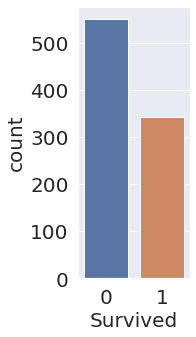

In [6]:
train_graph_df = train_df.copy()

def encode_str(s: str) -> int:
    return ord(s[0]) - ord('A') + 1

train_graph_df["Sex"] = train_graph_df["Sex"].map(encode_str)
train_graph_df["Embarked"] = train_graph_df["Embarked"].map(encode_str)
train_graph_df["Deck"] = train_graph_df["Deck"].map(encode_str)

if show_graphs:
  # show how many survived and didn't survive.
  plt.figure(figsize=(2,5))
  sns.countplot(x='Survived', data=train_df)
  plt.show()

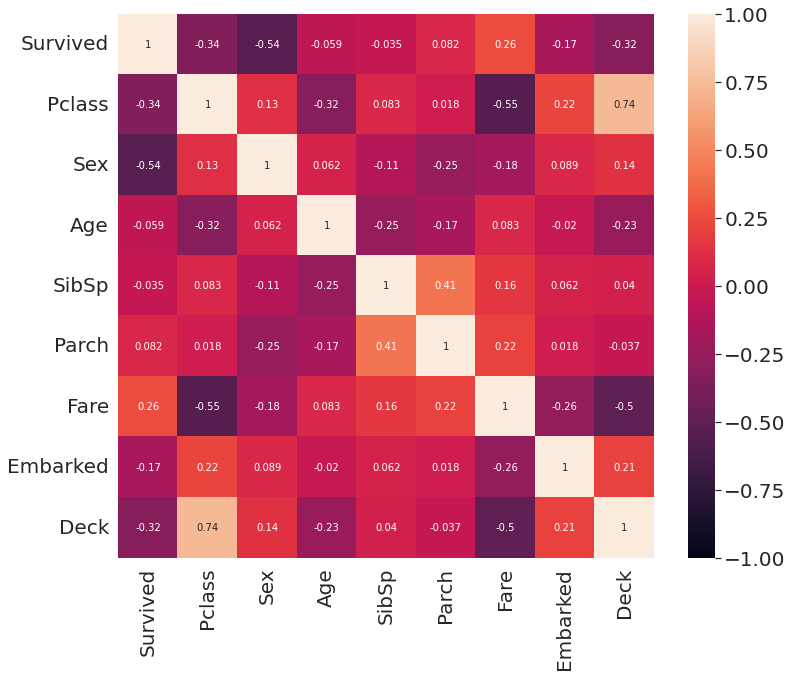

In [7]:
if show_graphs:
  # show correlation between all features
  plt.figure(figsize=(12,10))
  cor = train_graph_df.corr()
  sns.heatmap(cor, annot=True, vmin=-1, vmax=1)
  plt.show()

We can see that the features most correlated with survival are `Sex`, `PClass` and `Deck`, let's try to analyze those better.

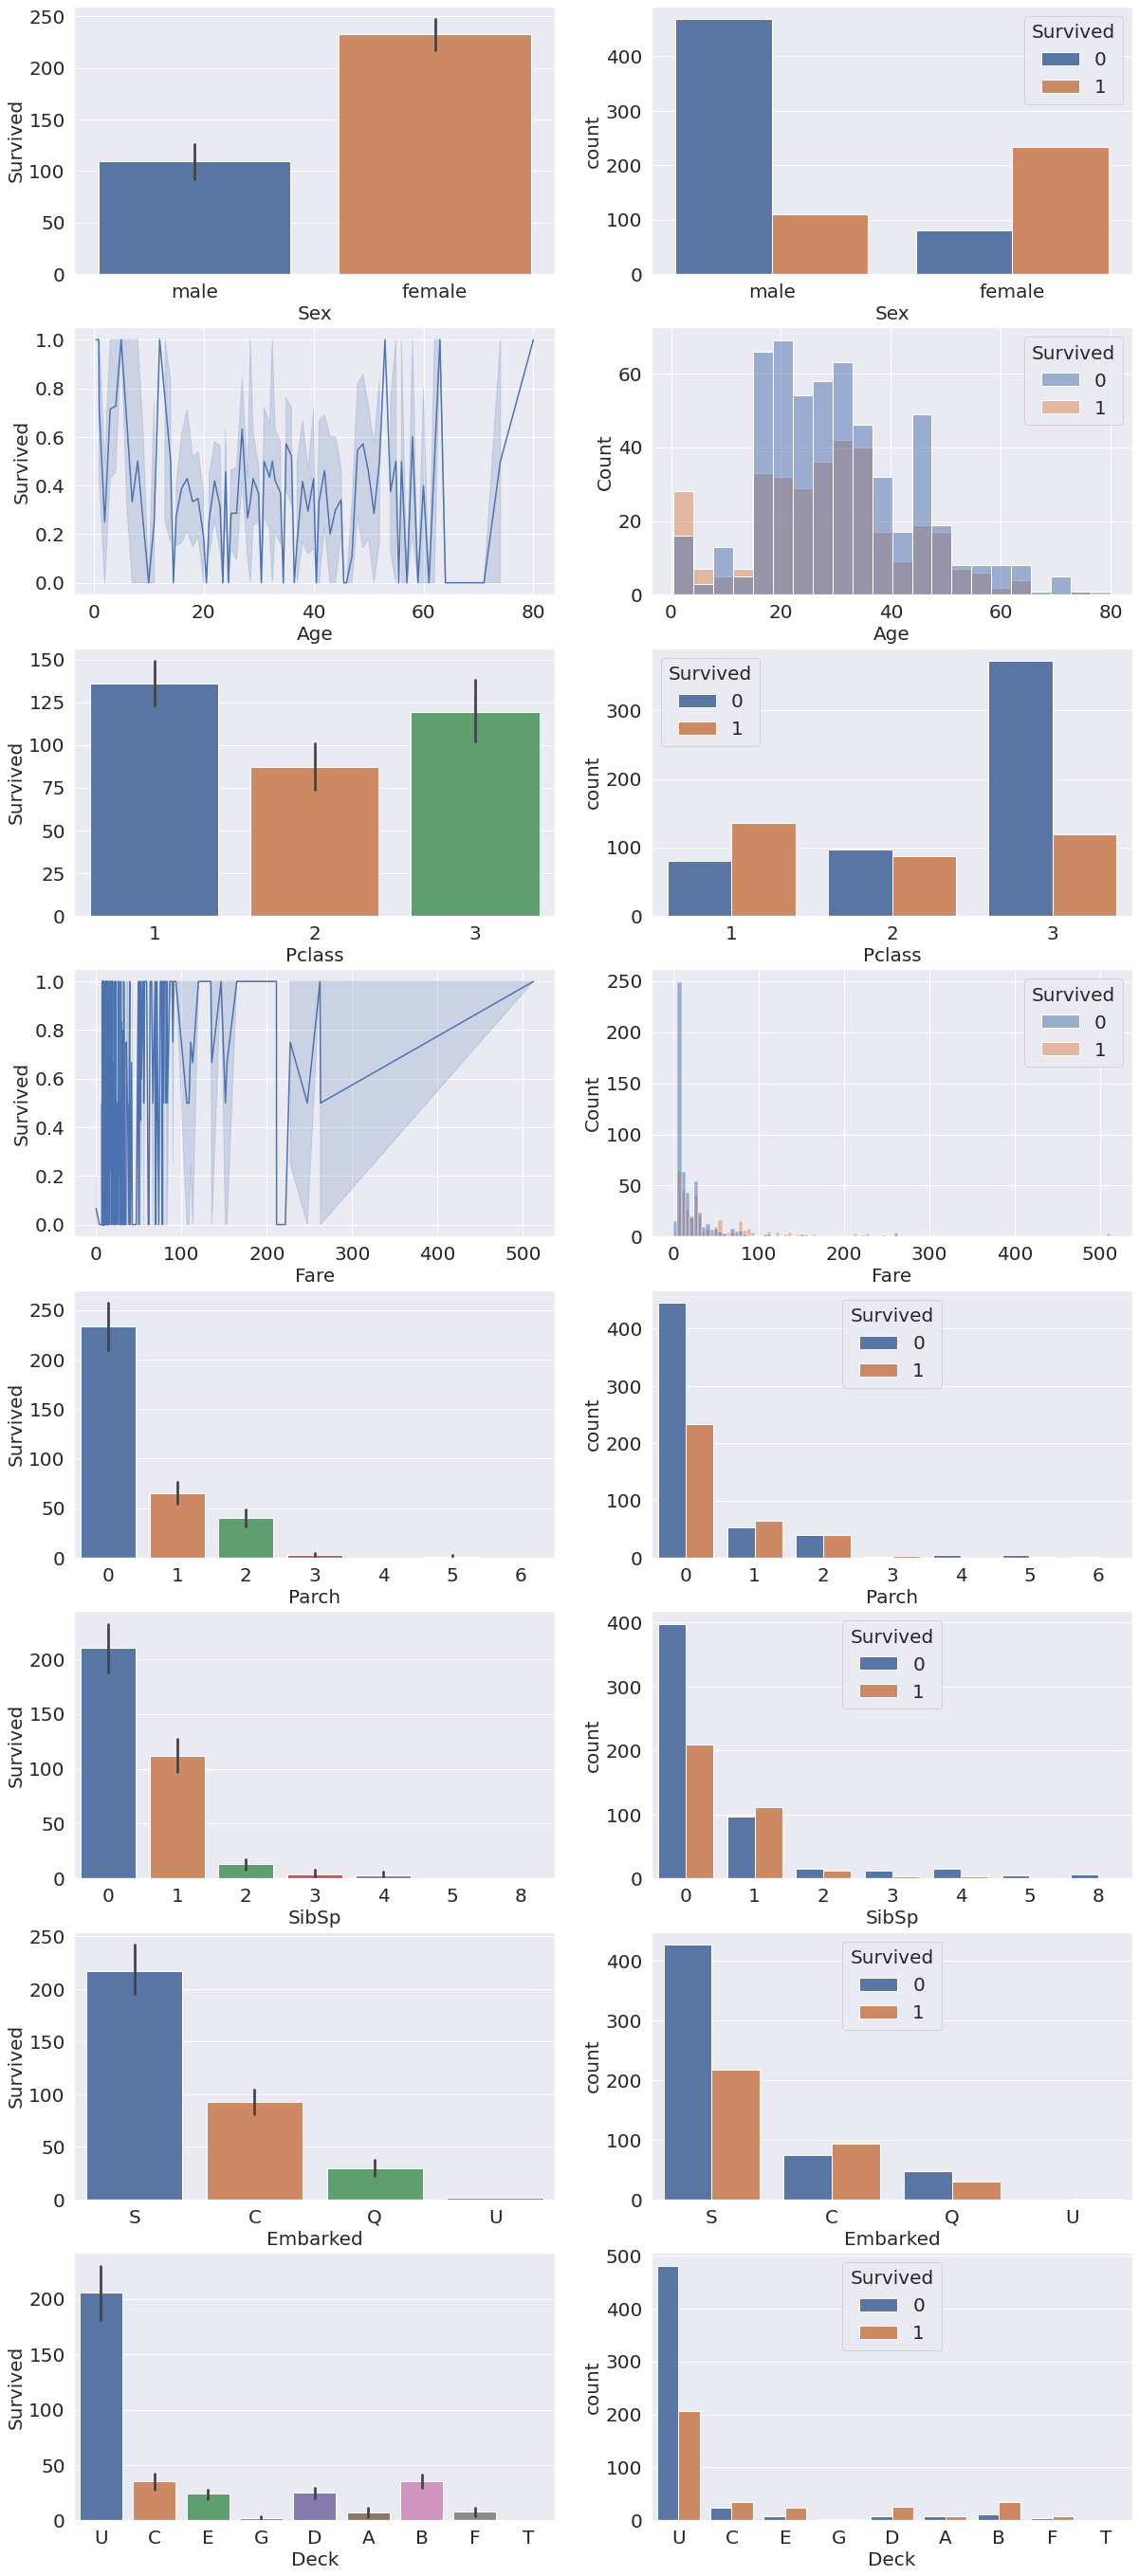

In [8]:
if show_graphs:
  # show count and survival rate from each column
  plt.figure(figsize=(20,55))

  plt.subplot(9,2,1)
  sns.barplot(x='Sex',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,2)
  sns.countplot(x='Sex', data=train_df, hue='Survived')

  plt.subplot(9,2,3)
  sns.lineplot(x='Age',y='Survived', data=train_df)
  plt.subplot(9,2,4)
  sns.histplot(x='Age', data=train_df, hue='Survived')

  plt.subplot(9,2,5)
  sns.barplot(x='Pclass',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,6)
  sns.countplot(x='Pclass', data=train_df, hue='Survived')

  plt.subplot(9,2,7)
  sns.lineplot(x='Fare',y='Survived', data=train_df)
  plt.subplot(9,2,8)
  sns.histplot(x='Fare', data=train_df, hue='Survived')

  plt.subplot(9,2,9)
  sns.barplot(x='Parch',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,10)
  sns.countplot(x='Parch', data=train_df,hue='Survived')

  plt.subplot(9,2,11)
  sns.barplot(x='SibSp',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,12)
  sns.countplot(x='SibSp', data=train_df,hue='Survived')

  plt.subplot(9,2,13)
  sns.barplot(x='Embarked',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,14)
  sns.countplot(x='Embarked', data=train_df,hue='Survived')

  plt.subplot(9,2,15)
  sns.barplot(x='Deck',y='Survived', data=train_df, estimator=np.sum)
  plt.subplot(9,2,16)
  sns.countplot(x='Deck', data=train_df,hue='Survived')

  plt.show()

Observations:
- Females survived at a better rate than men, and also in greater overall numbers.
- First class passengers survived at a better rate and quantity than other classes, while having fewer passengers
- Passengers that embarked from port `C` at a better rate of survival than other ports, but those from `S` port had the most survivors overall

Seems like we don't have enough features with high correlation, so let's add some hyper-features.

In [9]:
datasets = [train_df, test_df, train_graph_df]

# Add AgeClass category
for df in datasets:
    df['Age_Class'] = df['Age'] * df['Pclass']

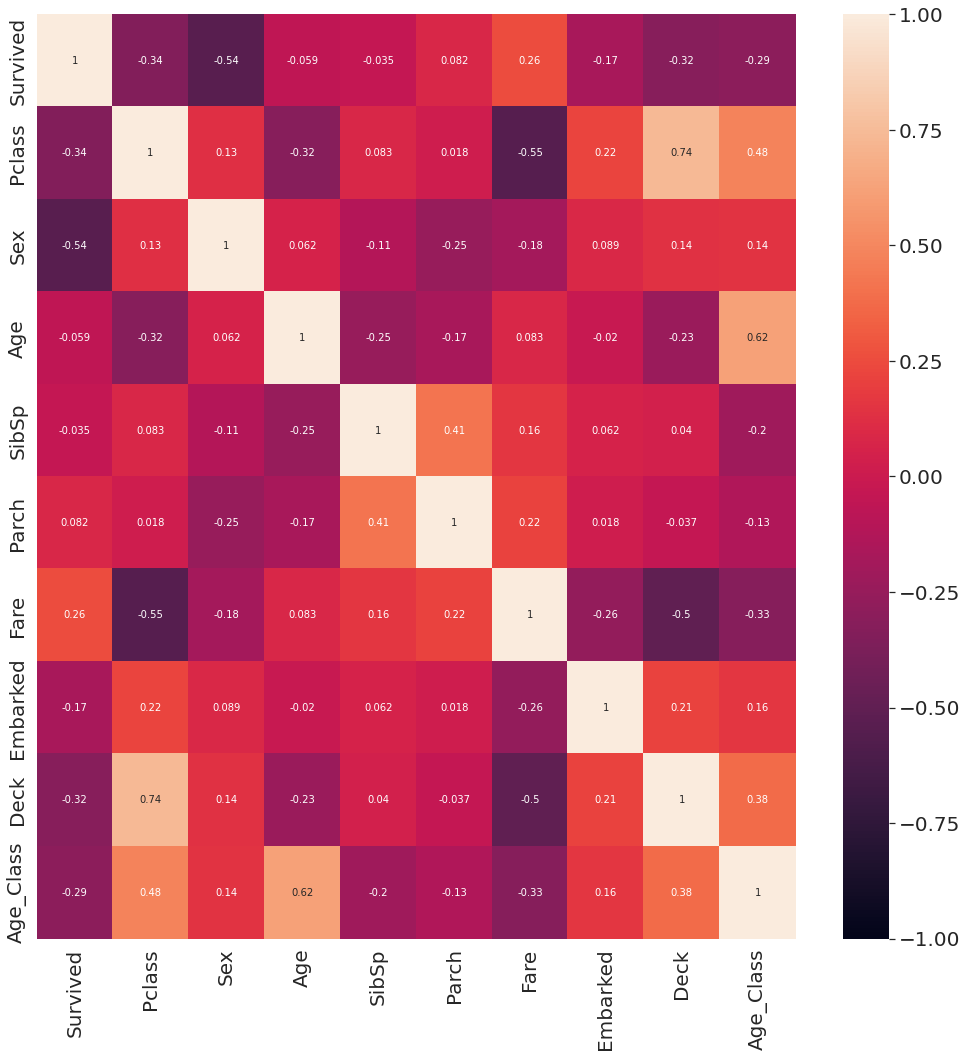

In [10]:
if show_graphs:
  # show correlation between all features after adding a new one
  plt.figure(figsize=(17,17))
  cor = train_graph_df.corr()
  sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
  plt.show()

We are now ready to move on to selecting and training our model.

# Training (Assignment 1)

### Before we select our model and train it, we ***encode*** the data so the model can process our data.

In [11]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

train_df_enc = train_df.drop(["Survived"], axis=1)
test_df_enc  = test_df.drop(["PassengerId"], axis=1)
train_df_enc['Sex'] = label.fit_transform(train_df_enc['Sex'])
test_df_enc['Sex'] = label.fit_transform(test_df_enc['Sex'])
train_df_enc['Embarked'] = label.fit_transform(train_df_enc['Embarked'])
test_df_enc['Embarked'] = label.fit_transform(test_df_enc['Embarked'])
train_df_enc['Deck'] = label.fit_transform(train_df_enc['Deck'])
test_df_enc['Deck'] = label.fit_transform(test_df_enc['Deck'])

In [12]:
# split the training dataframe into `X` - features, and `t` - target

X = train_df_enc
t = train_df["Survived"].copy()

In [13]:
# Assignment 1 training
logistic_regression = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.001))

TEST_SIZE = 0.3

# get accuracy and CE loss for a praticular x, t pair
def print_ce_acc_for_x(_X, _t, model):
    X_train, X_val, t_train, t_val = model_selection.train_test_split(_X, _t, test_size=TEST_SIZE, random_state=42)
    # create the classifier and predict the probabilities of the train and validation data
    model_cls = model.fit(X_train, t_train)
    y_train_prob = model_cls.predict_proba(X_train)
    y_val_prob = model_cls.predict_proba(X_val)
    print('CE on train', metrics.log_loss(t_train, y_train_prob))
    print('CE on validation', metrics.log_loss(t_val, y_val_prob))
    print('Accuracy score on train', model_cls.score(X_train, t_train))
    print('Accuracy score on validation', model_cls.score(X_val, t_val))
    print('-------')

print_ce_acc_for_x(X, t, logistic_regression) # all features

CE on train 0.4535239285690877
CE on validation 0.4321813443140061
Accuracy score on train 0.7929373996789727
Accuracy score on validation 0.8022388059701493
-------


# Assignment 3

### Encode and Normalize the data

In [14]:
train_df_enc = train_df.drop(["Survived"], axis=1)
test_df_enc  = test_df.drop(["PassengerId"], axis=1)

X = train_df_enc
t = train_df["Survived"].copy()

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# use column transformer to insert different transformers for each column
from sklearn.compose import ColumnTransformer

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
all_cols = list(categorical_cols) + list(numerical_cols)
ct_enc_std = ColumnTransformer([
            ("encoding", OrdinalEncoder(), categorical_cols),
            ("standard", StandardScaler(), numerical_cols)])
X_enc = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
test_X_enc = pd.DataFrame(ct_enc_std.fit_transform(test_df_enc), columns=X_enc.columns.values.tolist())
X = X_enc

In [15]:
def kpis(cm):
    tn, fp, fn, tp = cm.ravel()
    return {'precision' : round(tp/(tp+fp), 2),
            'recall' : round(tp/(tp+fn), 2),
            'specificity' : round(tn/(tn+fp), 2),
            'fpr' : round(fp/(fp+tn), 2),
            'accuracy' : round((tp+tn)/(tp+tn+fp+fn), 2)}

In [16]:
from sklearn.model_selection import cross_val_predict

def confusion_matrix_KPIs(cm):
  cm_df = pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

  sns.set(font_scale=2)
  plt.figure(figsize = (15,12))
  fig = sns.heatmap(cm_df, annot=True, cmap=plt.cm.Pastel2, fmt='g')
  fig.set_title("cm_val")
  plt.show()

  print(kpis(cm))

In [17]:
# calculate score and loss from cv (KFold or LPO) and display graphs
from sklearn.metrics import confusion_matrix
def get_cv_score_and_loss(X, t, model, k=None, p=None, show_score_loss_graphs=True, show_cm=False):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = RepeatedKFold(n_splits=k, n_repeats=10, random_state=1)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')

    conf_matrix_list_of_arrays = []
    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.loc[X.index.intersection(train_ids)]
        t_train = t.loc[t.index.intersection(train_ids)]
        X_val = X.loc[X.index.intersection(val_ids)]
        t_val = t.loc[t.index.intersection(val_ids)]

        model.fit(X_train, t_train)

        y_train = abs(model.predict(X_train))
        y_val = abs(model.predict(X_val))
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), metrics.log_loss(y_train, t_train)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), metrics.log_loss(y_val, t_val)]

        conf_matrix = confusion_matrix(t_val, y_val)
        conf_matrix_list_of_arrays.append(conf_matrix)

    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss(CE): {mean_val_loss:.2f}, Mean Train Loss(CE): {mean_train_loss:.2f}')
        fig.show()

    if show_cm:
      confusion_matrix_KPIs(mean_of_conf_matrix_arrays)

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss

# Hyper parameter search

In [18]:
hyper_parameters = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha':[0.0001, 0.001, 0.01, 0.1], 'learning_rate':['constant'], 'eta0':[0.0001, 0.001, 0.01, 0.1]}
gs_model = GridSearchCV(SGDClassifier(random_state=1), hyper_parameters, cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)).fit(X, t)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

Accuracy score for classification:
gs_model 0.791032459425718
best params {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'elasticnet'}


# Feature Selection

In [19]:
selector = RFECV(SGDClassifier(random_state=1, alpha=gs_model.best_params_['alpha'], learning_rate='constant', eta0=gs_model.best_params_['eta0'], penalty=gs_model.best_params_['penalty']), cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)).fit(X, t)
selector_df = X.loc[:, selector.support_]
selector_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


,Sex,Embarked,Deck,Pclass,Age,SibSp,Parch,Fare,Age_Class
0,1.0,2.0,8.0,0.827377,-0.542813,0.432793,-0.473674,-0.502445,0.035237
1,0.0,0.0,2.0,-1.566107,0.591896,0.432793,-0.473674,0.786845,-0.741934
2,0.0,2.0,8.0,0.827377,-0.259135,-0.474545,-0.473674,-0.488854,0.368311
3,0.0,2.0,2.0,-1.566107,0.379138,0.432793,-0.473674,0.420730,-0.825202
4,1.0,2.0,8.0,0.827377,0.379138,-0.474545,-0.473674,-0.486337,1.117726
...,...,...,...,...,...,...,...,...,...
886,1.0,2.0,8.0,-0.369365,-0.188216,-0.474545,-0.473674,-0.386671,-0.297836
887,0.0,2.0,1.0,-1.566107,-0.755570,-0.474545,-0.473674,-0.044381,-1.269300
888,0.0,2.0,8.0,0.827377,1.088330,0.432793,2.008933,-0.176263,1.950409
889,1.0,0.0,2.0,-1.566107,-0.259135,-0.474545,-0.473674,-0.044381,-1.075007


## Testing selected features vs. all features (for different K in KFold)

all features:

In [20]:
SGD_cls = pipeline.make_pipeline(SGDClassifier(loss='log', alpha=gs_model.best_params_['alpha'], learning_rate='constant', eta0=gs_model.best_params_['eta0'], penalty=gs_model.best_params_['penalty'], random_state=1)).fit(X, t)
get_cv_score_and_loss(X, t, SGD_cls, k=10, show_score_loss_graphs=show_graphs)

(0.7933920099875152, 7.136098347424647, 0.8018332757369994, 6.844545543128446)

selected:

In [21]:
if len(selector_df.columns) != len(X.columns): # check selected only if different than all
  SGD_cls_selector = pipeline.make_pipeline(SGDClassifier(loss='log', alpha=gs_model.best_params_['alpha'], learning_rate='constant', eta0=gs_model.best_params_['eta0'], penalty=gs_model.best_params_['penalty'], random_state=1)).fit(selector_df, t)
  get_cv_score_and_loss(selector_df, t, SGD_cls_selector, k=10, show_score_loss_graphs=show_graphs)

# KNN vs LDA vs NBC

In [22]:
hyper_parameters = {'n_neighbors': list(range(1, 100))}

# KNN
gs_neigh_model = GridSearchCV(KNeighborsClassifier(), hyper_parameters, cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)).fit(selector_df, t)
print('Accuracy score for classification:')
print('gs_neigh_model', gs_neigh_model.best_score_)
print('best params', gs_neigh_model.best_params_)

Accuracy score for classification:
gs_neigh_model 0.7946229712858925
best params {'n_neighbors': 25}


In [23]:
# lda
print('LinearDiscriminantAnalysis score:', cross_val_score(LinearDiscriminantAnalysis(), selector_df, t, cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)).mean())

LinearDiscriminantAnalysis score: 0.7933832709113608


In [24]:
# nbc
from sklearn.naive_bayes import MultinomialNB

# print('MultinomialNB score:', cross_val_score(MultinomialNB(), selector_df, t, cv=15).mean()) # fails for negative values

# Ensembles

bagging:

In [25]:
from sklearn.ensemble import BaggingClassifier

hyper_parameters = {'base_estimator' : [SGDClassifier(loss='log', alpha=gs_model.best_params_['alpha'], learning_rate='constant', eta0=gs_model.best_params_['eta0'], penalty=gs_model.best_params_['penalty'], random_state=1),
                                        KNeighborsClassifier(n_neighbors=gs_neigh_model.best_params_['n_neighbors'])],
                    'n_estimators' : list(range(1, 50)),
                    'bootstrap' : [True, False]}

bag_fold_model = GridSearchCV(BaggingClassifier(), hyper_parameters).fit(selector_df, t)
print('Accuracy score for classification:')
print('gs_bag_model', bag_fold_model.best_score_)
print('best params', bag_fold_model.best_params_)

Accuracy score for classification:
gs_bag_model 0.7901638315234448
best params {'base_estimator': SGDClassifier(alpha=0.001, eta0=0.001, learning_rate='constant', loss='log',
              penalty='elasticnet', random_state=1), 'bootstrap': True, 'n_estimators': 1}


Ada booster:

In [39]:
from sklearn.ensemble import AdaBoostClassifier
hyper_parameters = {'n_estimators' : list(range(1, 100))}

boost_fold_model = GridSearchCV(AdaBoostClassifier(), hyper_parameters).fit(selector_df, t)
print('Accuracy score for classification:')
print('gs_bag_model', boost_fold_model.best_score_)
print('best params', boost_fold_model.best_params_)

Accuracy score for classification:
gs_bag_model 0.8092649551189505
best params {'n_estimators': 27}


### We can see that Adabooster is the best model.

In [32]:
classifier = pipeline.make_pipeline(AdaBoostClassifier(n_estimators=boost_fold_model.best_params_['n_estimators'])).fit(selector_df, t)

# ```CV``` score and loss, ```CM``` and ```KPIs``` of our final model:

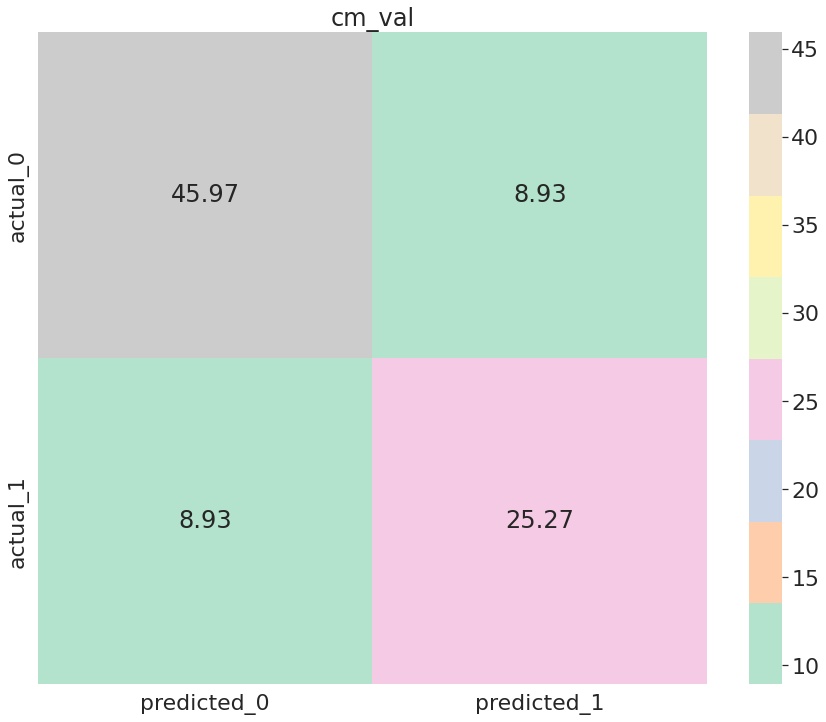

{'precision': 0.74, 'recall': 0.74, 'specificity': 0.84, 'fpr': 0.16, 'accuracy': 0.8}


(0.7995505617977529, 6.92335846198422, 0.8282082714561916, 5.9335460671354925)

In [33]:
get_cv_score_and_loss(selector_df, t, classifier, k=10, show_cm=True)

### we can see our model gives us high specificity but much lower recall and precision

# Submission

In [30]:
X_test = test_X_enc.loc[:, selector.support_]
prediction = classifier.predict(X_test)

output = pd.DataFrame({'PassengerId' : test_df['PassengerId'], 'Survived' : prediction})
output.to_csv('submission.csv',index=False)

# Kaggle Results

![leaderboard](https://i.imgur.com/bVnusgQ.png)
![runs](https://i.imgur.com/qxlzKkf.png)

# Thoughts and summary
- From what I've read online LogisticRegression should perform the best so unless I'm missing something our results using a different model are expected.

# Sources Used:
- https://www.kaggle.com/alexisbcook/titanic-tutorial
- predicting-the-survival-of-titanic-passengers-30870ccc7e8
- labs 07 + 08
